1. input svg
2. deconstruct svg into layers
3. prepare each layer (masking), some layers have interaction
4. parse through terrain algorithm to get heightmap

In [1]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import get_city_coordinates, get_island_coordinates
from image_ops import flood_image

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

In [2]:
realm_number = 4726

In [11]:
config = OmegaConf.load("../pipeline/config.yaml")
# this is how you can access the config
# we will use padding more often
p = config.svg.padding
p = 40
config

{'svg': {'scaling': 2.0, 'padding': 43, 'city_alpha': 1.25, 'island_alpha': 1.575}, 'pipeline': {'use_rivers': True, 'use_cities': True, 'use_islands': True}, 'terrain': {'mountains': 10}}

In [17]:
extractor = SVGExtractor(f"../svgs/{realm_number}.svg")

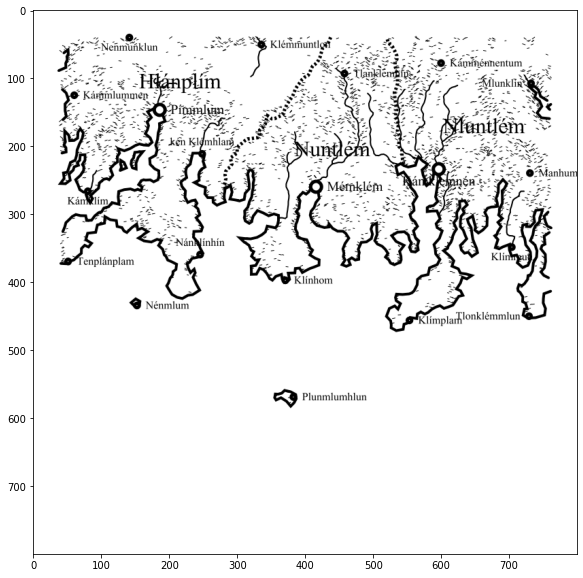

In [18]:
extractor.show()

In [19]:
drawing = extractor.coast()
island_centers = get_island_coordinates(
    drawing,
    padding=p,
    alpha=config.svg.island_alpha
)
# also get the coast image, we will use this later
coast_img = extractor.get_img()

In [20]:
drawing = extractor.cities()
city_centers = get_city_coordinates(
    drawing,
    padding=p,
    alpha=config.svg.city_alpha
)

In [21]:
# some small checks
for city_center in city_centers:
    assert 0 <= city_center[0] < drawing.width
    assert 0 <= city_center[1] < drawing.height
    
for island_center in island_centers:
    assert 0 <= island_center[0] < drawing.width
    assert 0 <= island_center[1] < drawing.height

In [22]:
# we will now use islands centers and cities to fill land.
# surely we will miss some parts, but we can fix that later

flooded_image = flood_image(
    coast_img,
    [
        city_centers,
        island_centers
    ], config.svg.padding)

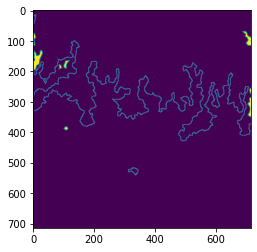

In [23]:
# check the intermediate result
plt.imshow(flooded_image)

In [24]:
extractor.rivers()
rivers = np.asarray(extractor.get_img())[p:-p,p:-p,0]

In [25]:
final_mask = (flooded_image-255)*255-(rivers<255)*255
final_mask = (final_mask > 254) * 255

# sanity check to only have 0 and 255
assert np.unique(final_mask).shape[0] == 2
plt.imshow(final_mask)

ValueError: operands could not be broadcast together with shapes (714,714) (720,720) 

# terrain generation

In [ ]:
# this is still most copy pasta
dim = int(drawing.height)-p*2
shape = (dim,) * 2
disc_radius = 1.0
max_delta = 0.04
river_downcutting_constant = 1.3
directional_inertia = 0.4
default_water_level = 1.0
evaporation_rate = 0.2

print ('Generating...')

print('  ...initial terrain shape')
land_mask = remove_lakes(
  (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - 1.1) > 0)
land_mask = final_mask > 0
coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / 80.0) * land_mask
mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
initial_height = ( 
  (util.gaussian_blur(np.maximum(mountain_shapes - 0.40, 0.0), sigma=5.0) 
    + 0.1) * coastal_dropoff)
deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

print('  ...sampling points')
points = util.poisson_disc_sampling(shape, disc_radius)
coords = np.floor(points).astype(int)

print('  ...delaunay triangulation')
tri = sp.spatial.Delaunay(points)
(indices, indptr) = tri.vertex_neighbor_vertices
neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
points_land = land_mask[coords[:, 0], coords[:, 1]]
points_deltas = deltas[coords[:, 0], coords[:, 1]]

print('  ...initial height map')
points_height = compute_height(points, neighbors, points_deltas)

print('  ...river network')
(upstream, downstream, volume) = compute_river_network(
  points, neighbors, points_height, points_land,
  directional_inertia, default_water_level, evaporation_rate)

print('  ...final terrain height')
new_height = compute_final_height(
  points, neighbors, points_deltas, volume, upstream, 
  max_delta, river_downcutting_constant)
terrain_height = render_triangulation(shape, tri, new_height)



In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(terrain_height)

# export

In [ ]:
qmap = (terrain_height*255).astype(np.uint8)
qimg = PIL.Image.fromarray(qmap).convert('L')
qimg.save(f"../output/height_{realm_number}.png")